In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# import cupy as cp

In [2]:
def load_data(data, num_timepoints):
    data = np.memmap(data, dtype = np.int16, mode='r',shape=(num_timepoints,9))
    data = pd.DataFrame(data[:,8])
    return data

def to_binary_string(x):
    return format(x, '07b')

def split_binary_string(binary_str):
    return list(binary_str)

def nidq(data):

    #to binary string
    binary_data = data.applymap(to_binary_string)

    #split binary string
    split_data = binary_data[0].apply(split_binary_string)
    return pd.DataFrame(split_data.tolist(), columns = ['LASER', '_', 'SYNC', '_', '_', '_','Sync'])

In [3]:
file_size = os.path.getsize('N03_20240808_ST_05P175L3V_FIX_BMI_g4/N03_20240808_ST_05P175L3V_FIX_BMI_g4_t0.nidq.bin')
num_samples = file_size//np.dtype(np.int16).itemsize
num_timepoints = num_samples // 9

In [4]:
num_timepoints

40151424

In [8]:
path = 'N03_20240808_ST_05P175L3V_FIX_BMI_g4/N03_20240808_ST_05P175L3V_FIX_BMI_g4_t0.nidq.bin'

In [9]:
data_nidq = load_data(path, num_timepoints)
data_nidq = nidq(data_nidq)
data_nidq

C:\Users\user\AppData\Local\Temp\ipykernel_3692\3351689876.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_data = data.applymap(to_binary_string)


,LASER,_,SYNC,_,_,_,Sync
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
40151419,0,0,0,0,0,0,1
40151420,0,0,0,0,0,0,1
40151421,0,0,0,0,0,0,1
40151422,0,0,0,0,0,0,1


In [36]:
np.unique(data_nidq.SYNC)

array(['0', '1'], dtype=object)

In [55]:
data_nidq[['SYNC','LASER']].describe()

,SYNC,LASER
count,40151424,40151424
unique,2,2
top,0,0
freq,40096126,40063718


In [10]:
data_x = data_nidq[['SYNC','LASER']]

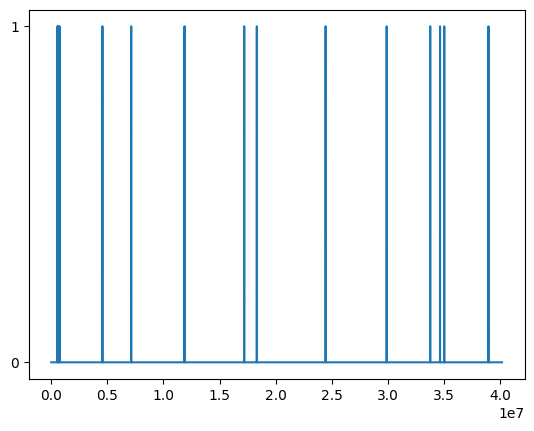

In [11]:
plt.plot(data_x.SYNC[0:40151423])

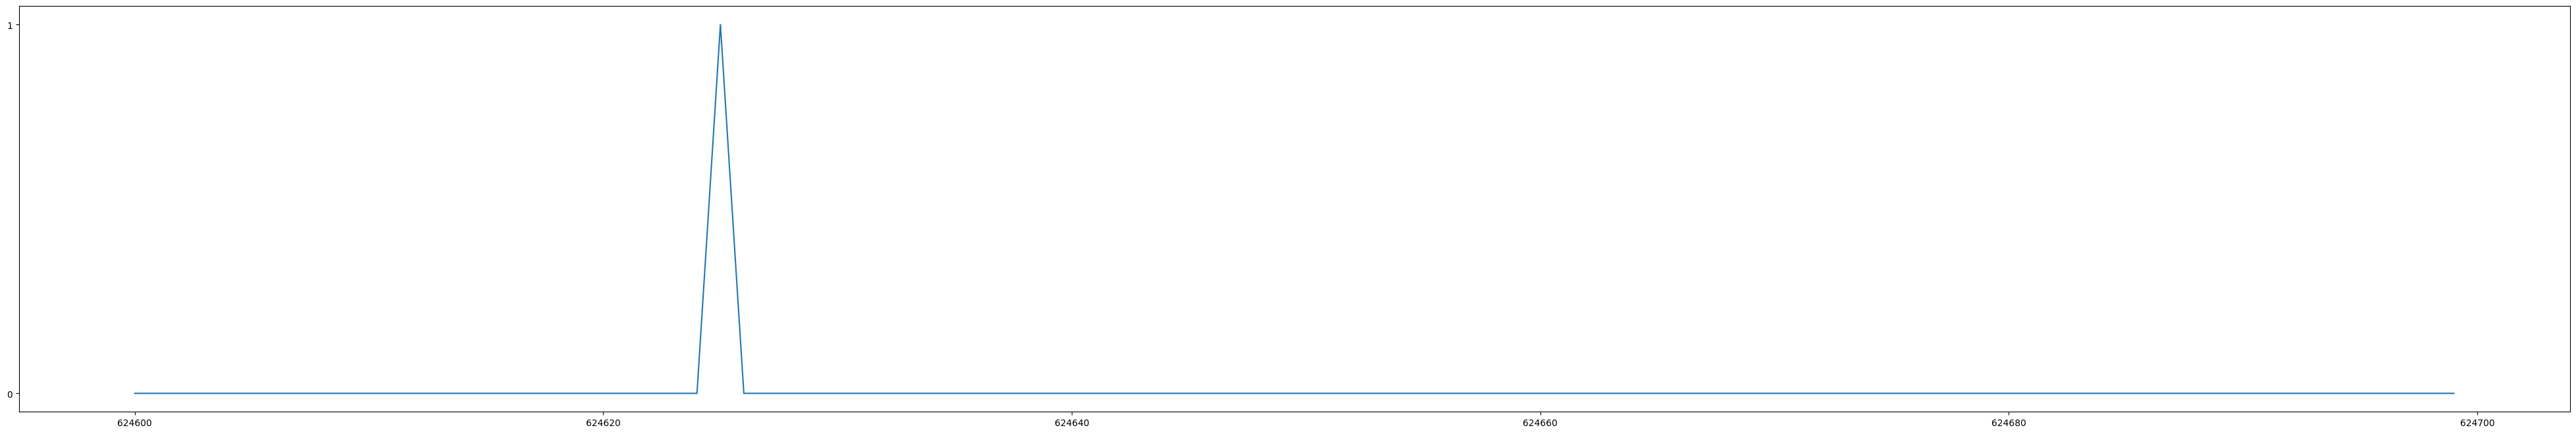

In [12]:
plt.figure(figsize=(50,8))
plt.plot(data_x.LASER[624600:624700])

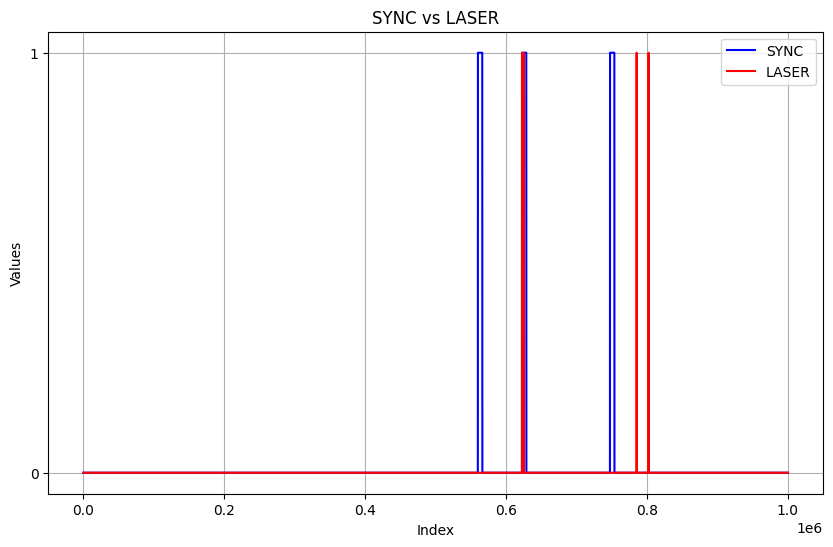

In [13]:
# sync laser
plt.figure(figsize=(10, 6))
plt.plot(data_x['SYNC'][0:1000000], label='SYNC', color='blue')
plt.plot(data_x['LASER'][0:1000000], label='LASER', color='red')

plt.title('SYNC vs LASER')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Convert int32 to int16

def Int32toInt16(file_name):
    # load int32 file
    data_int32 = np.memmap(file_name, dtype=np.int32,mode='r')
    # convert int32 to int16
    data_int16 = data_int32.astype(np.int16)
    
    return data_int16
    
# Convert and save the int16 file
data_int16 = np.memmap('spk/mua_16.bin', dtype=np.int16,mode='w+',shape = mua.shape) # create new file for int16
data_int16[:] = Int32toInt16('spk/mua.bin')
data_int16.flush()
data_int16

In [14]:
file_size = os.path.getsize('spk/mua.bin')
num_samples = file_size//np.dtype(np.int32).itemsize
num_timepoints = num_samples // 160

In [15]:
mua = np.memmap('spk/mua.bin', dtype = np.int32, mode='r',shape=(num_timepoints,160))
mua =  pd.DataFrame(mua)
mua.iloc[:, 20:24]

,20,21,22,23
0,2001510,2020094,1918980,1949324
1,3564384,3601998,3423072,3471760
2,5227234,5281462,5023018,5094032
3,7597190,7673940,7299138,7397998
4,11175350,11281144,10733360,10876622
...,...,...,...,...
15616753,-135784,522256,-84050,60714
15616754,21034,734062,67870,54972
15616755,206002,937016,245988,112690
15616756,411902,1093918,407244,219142


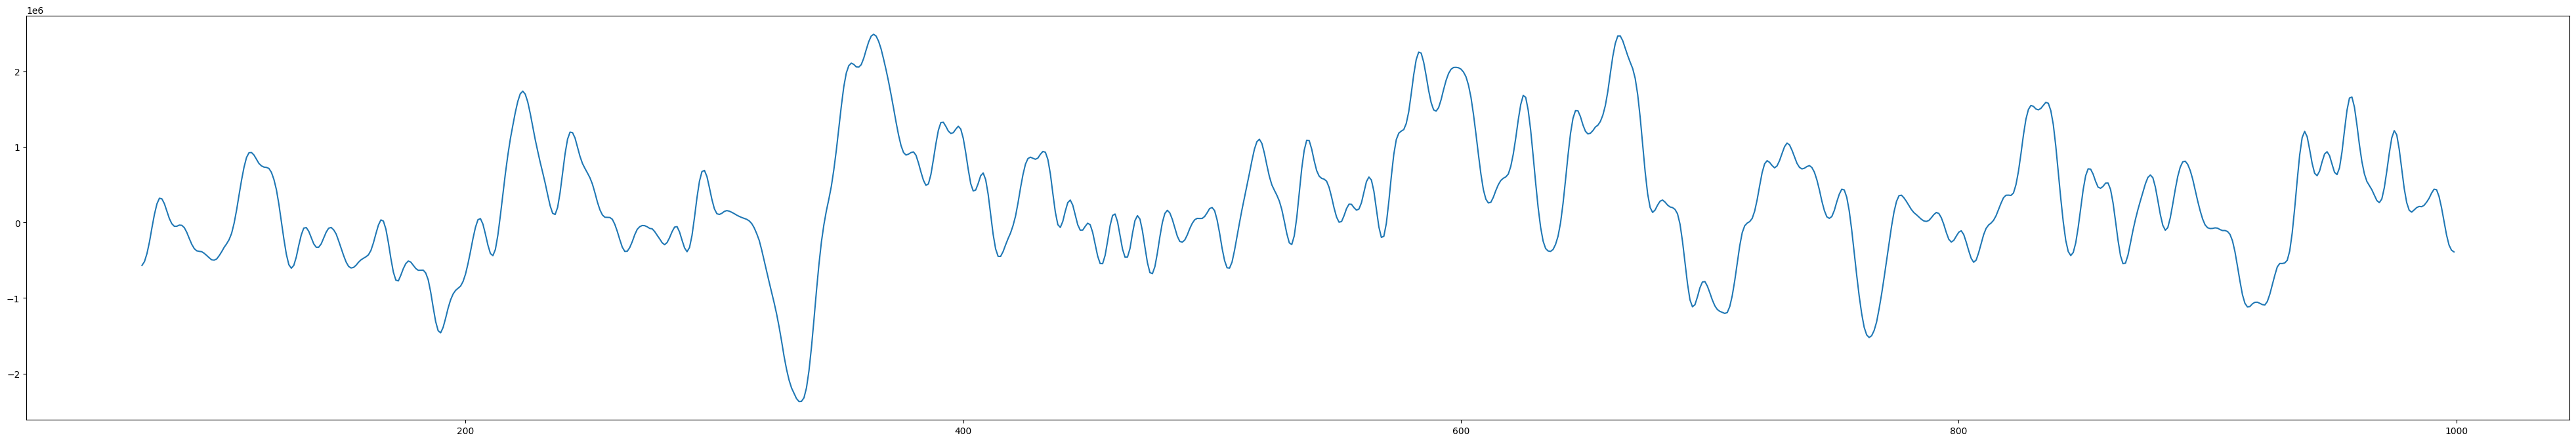

In [16]:
plt.figure(figsize=(50,8))
plt.plot(mua[20][70:1000])
plt.show()

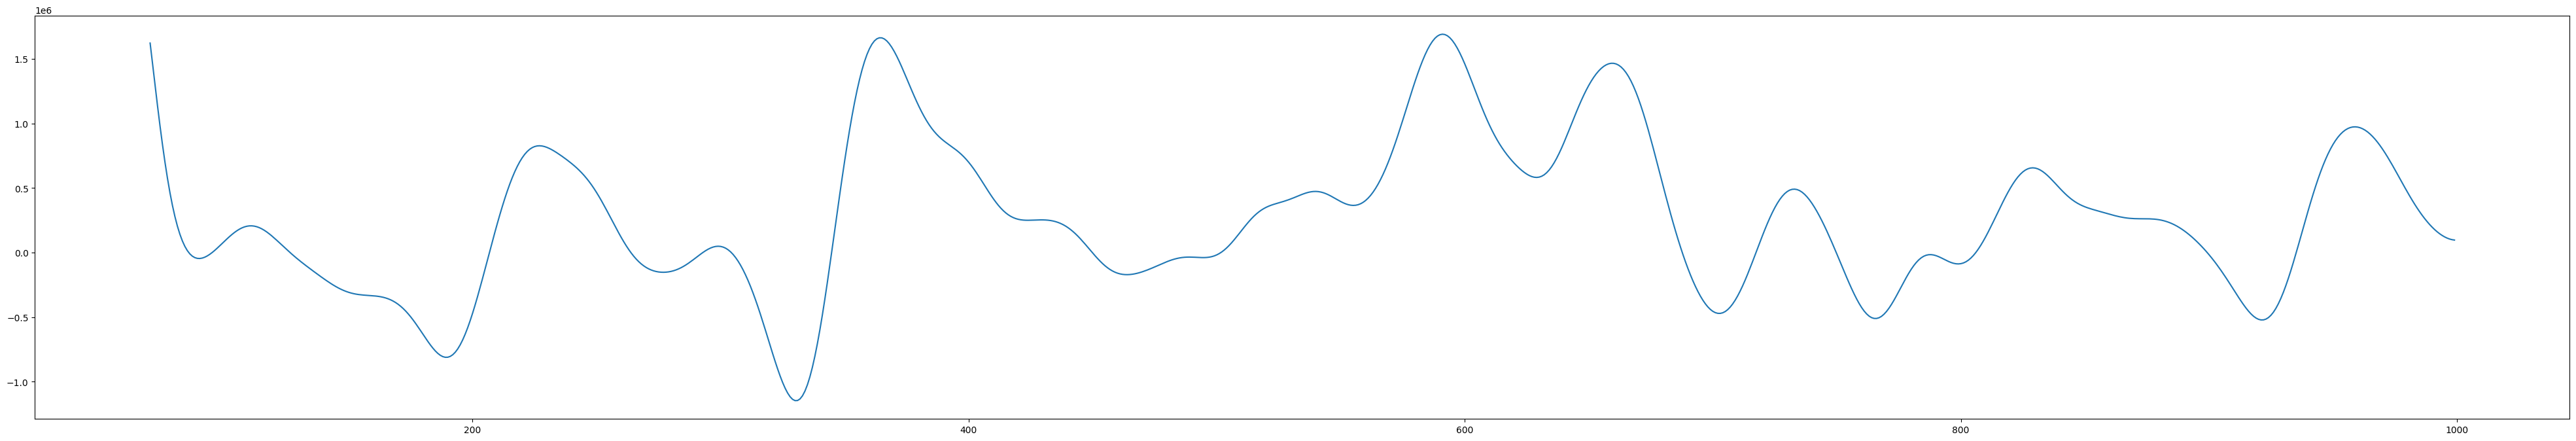

In [129]:
from scipy.ndimage import gaussian_filter
filtered_mua = mua.copy()
filtered_mua.iloc[:, 20:24] = gaussian_filter(mua.iloc[:, 20:24], sigma=10)

plt.figure(figsize=(50,8))
plt.plot(filtered_mua[20][70:1000])
plt.show()

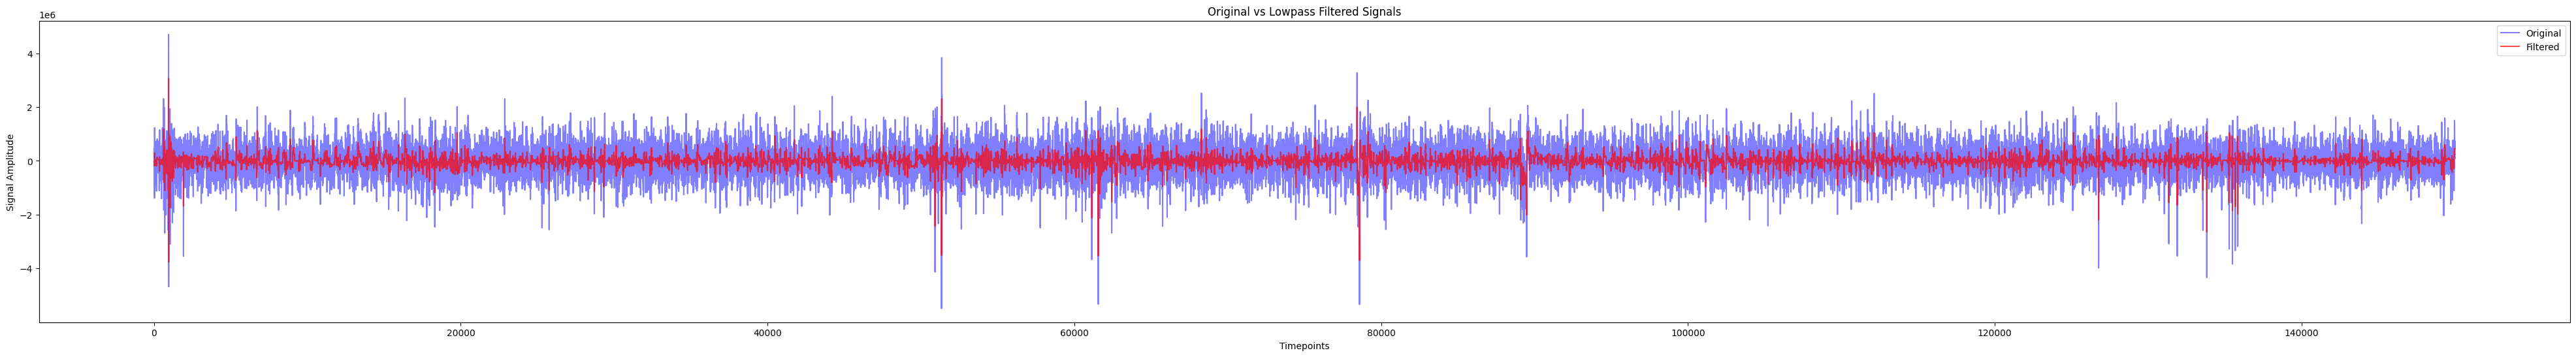

In [178]:
from scipy.signal import butter, filtfilt
import pywt

mua_20 = mua[20]

def wavelet_denoise(data, wavelet='db1', level=2):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    threshold = np.std(coeffs[-level]) * np.sqrt(2 * np.log(len(data)))
    coeffs = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs, wavelet, mode='per')

filtered_mua_20 = wavelet_denoise(mua_20)


plt.figure(figsize=(50, 6))
plt.plot(mua_20[1150000:1300000].values, color='blue', alpha=0.5, label='Original')
plt.plot(filtered_mua_20[1150000:1300000], color='red', alpha=0.7, label='Filtered')
plt.xlabel('Timepoints')
plt.ylabel('Signal Amplitude')
plt.title('Original vs Lowpass Filtered Signals')
plt.legend()
plt.show()

In [92]:
df = pd.read_pickle('spk/spktag/model.pd')
np.unique(df.spike_id)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [91]:
df

,frame_id,group_id,fet0,fet1,fet2,fet3,spike_id
0,15.0,0.0,0.135805,0.030960,-2.066495e-01,-2.752960e-01,0.0
1,15.0,29.0,0.978670,0.001688,-7.857964e-07,-1.129977e-06,0.0
2,15.0,1.0,0.118503,0.095251,-9.423795e-02,6.277092e-01,5.0
3,15.0,28.0,0.982304,0.001674,8.098354e-06,-2.823010e-06,0.0
4,15.0,27.0,0.977766,0.001666,1.415351e-06,1.052859e-07,0.0
...,...,...,...,...,...,...,...
223663,13709594.0,14.0,0.014518,-0.008517,-2.352209e-02,-2.341546e-02,0.0
223664,13709594.0,15.0,-0.020000,-0.003950,-2.994643e-02,-1.983664e-02,0.0
223665,13709807.0,4.0,0.005111,0.003622,9.023414e-04,-1.129256e-02,0.0
223666,13709887.0,7.0,-0.025718,0.002803,2.171260e-03,-7.130542e-04,0.0


In [255]:
np.unique(df[df.spike_id == 16].frame_id)

array([   28673.,    75422.,    78669., ..., 13664544., 13664874.,
       13667733.])

In [237]:
np.unique(df[df.group_id == 5].spike_id)

array([ 0., 16., 17., 18.])

In [224]:
spk = np.memmap('spk/spk.bin', dtype = np.int32, mode='r')
spk = pd.DataFrame(spk.reshape(-1,2))
spk

,0,1
0,15,96
1,15,66
2,15,68
3,15,104
4,15,105
...,...,...
449478,15616658,1
449479,15616660,12
449480,15616673,1
449481,15616676,21


In [258]:
spk_wav = np.memmap('spk/spk_wav.bin', dtype = np.int32, mode='r',shape=(405918, 20, 4))
spk_wav[:,0,:]

memmap([[       0,      103,       15,       24],
        [       0,       75,       15,       18],
        [       0,       85,       15,       22],
        ...,
        [       0,       11, 15616673,        2],
        [       0,       21, 15616676,        6],
        [       0,       31, 15616677,        0]])

In [268]:
# def load_spike(spike_file):
#         df = pd.read_pickle(spike_file)
#         n_unit = int(df['spike_id'].max())
#         spike_time = np.zeros(n_unit, dtype=object)
#         spike_fr = np.zeros(n_unit)
#         spike_group = np.zeros(n_unit, dtype=int)

#         duration = (df['frame_id'].iloc[-1] - df['frame_id'].iloc[0]) / 25000

#         for i_unit in range(n_unit):
#             in_unit = df['spike_id'] == (i_unit + 1)
#             if sum(in_unit) == 0:
#                 continue
#             spike_group[i_unit] = np.unique(df['group_id'][in_unit])[0]
#             spike_time[i_unit] = df['frame_id'][in_unit].to_numpy() / 25000
#             spike_fr[i_unit] = sum(in_unit) / duration

#         return spike_group, spike_time, spike_fr

# spike_group, spike_time, spike_fr = load_spike('spk/spktag/model.pd')
# target_unit_time = df[df.spike_id == 16].frame_id.astype(np.int64)
# indices = target_unit_time.to_numpy()
# mua['target_unit'] = 0
# mua.loc[indices, 'target_unit'] = 1

In [17]:
mua

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,1772610,1746570,1814504,1814190,1959300,2009174,1842540,2075534,1930004,1923074,...,-3699634,-3701420,-3701420,-3700790,-3703940,-3702154,-3702890,-3700580,-3704674,-3703834
1,3171108,3127568,3242046,3244950,3505170,3590950,3292920,3707664,3439766,3439814,...,-6385830,-6387854,-6389954,-6387678,-6394652,-6389478,-6390262,-6388248,-6394282,-6392156
2,4646292,4587590,4744348,4750328,5137424,5265722,4824440,5430392,5036786,5038248,...,-9236924,-9237320,-9241164,-9236518,-9245910,-9240744,-9241412,-9238808,-9246306,-9242572
3,6749058,6666596,6895420,6890634,7457934,7654426,7004576,7888818,7319016,7318596,...,-13299688,-13298148,-13305074,-13297674,-13310618,-13303018,-13304714,-13300562,-13311532,-13305012
4,9936268,9797790,10151444,10136190,10966724,11257404,10305036,11605254,10762824,10765880,...,-19423270,-19422542,-19431654,-19424100,-19441610,-19431018,-19433798,-19426244,-19442356,-19432298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15616753,-330534,-33810,292672,8954,182352,-259260,-346814,-390782,200098,538740,...,-58166,80992,-29556,-78172,119138,15590,-10640,-11408,-28324,56330
15616754,-273610,-121582,392316,-67968,140378,-24540,-389874,-372808,385024,665056,...,-71396,62470,-30610,-41476,82108,7332,-18698,-13448,-30780,60140
15616755,-142422,-137732,441256,-120842,36096,289998,-398766,-267326,594076,771872,...,-68008,25372,-29796,-3682,27330,-8336,-31274,-15996,-32704,55208
15616756,41630,-18330,424194,-132530,-83136,603924,-369996,-82804,747470,835968,...,-55036,-21894,-21880,26594,-28558,-28674,-44966,-14498,-29718,47000


# SYNC

In [18]:
from scipy.interpolate import interp1d

In [19]:
niSampRate=62500.163636  # real : 62500.163636

In [20]:
# check laser (about 312.5 is 5ms)
start_indices = np.where(np.diff(data_x.LASER.astype(np.int64)) > 0)[0] + 1
end_indices = np.where(np.diff(data_x.LASER.astype(np.int64)) < 0)[0] + 1
end_indices - start_indices  # 5ms

array([312,   1, 312, 313, 312, 312, 312, 313, 312, 312, 312, 313, 312,
       312, 313, 313, 313, 313, 313, 312, 312, 312, 312, 312, 312, 313,
       313, 312, 312, 313, 313, 313, 312, 312, 312, 312, 312, 312, 313,
       312, 313, 312, 312, 313, 312, 312, 312, 312, 313, 312, 313, 312,
       312, 312, 313, 312, 312, 312, 312, 313, 312, 313, 312, 312, 313,
       313, 312, 312, 313, 312, 312, 313, 312, 313, 312, 312, 312, 312,
       312, 312, 313, 313, 312, 312, 312, 313, 312, 312, 312, 313, 313,
       312, 313, 313, 313, 313, 312, 313, 313, 313, 312, 313, 312, 313,
       312, 312, 313, 313, 313, 313, 312, 312, 313, 312, 313, 312, 312,
       313, 313, 312, 312, 313, 312, 313, 312, 313, 313, 312, 312, 312,
       313, 312, 313, 312, 312, 312, 312, 312, 312, 312, 312, 313, 312,
       313, 313, 313, 313, 313, 312, 313, 313, 312, 313, 313, 312, 312,
       312, 313, 313, 312, 313, 313, 312, 312, 313, 312, 312, 313, 313,
       313, 313, 312, 312, 312, 312, 312, 312, 312], dtype=int64

In [21]:
# remove laser under 1ms duration
NI_data = data_x.astype(np.int64)
ms_threshold = niSampRate / 1000 # 1ms
for start, end in zip(start_indices, end_indices):
    if (end - start) < ms_threshold:
        NI_data.loc[start:end-1, 'LASER'] = 0

In [22]:
start_indices = np.where(np.diff(NI_data.LASER.astype(np.int64)) > 0)[0] + 1
end_indices = np.where(np.diff(NI_data.LASER.astype(np.int64)) < 0)[0] + 1
laser_durations = end_indices - start_indices  # 5ms
laser_durations

array([312, 312, 313, 312, 312, 312, 313, 312, 312, 312, 313, 312, 312,
       313, 313, 313, 313, 313, 312, 312, 312, 312, 312, 312, 313, 313,
       312, 312, 313, 313, 313, 312, 312, 312, 312, 312, 312, 313, 312,
       313, 312, 312, 313, 312, 312, 312, 312, 313, 312, 313, 312, 312,
       312, 313, 312, 312, 312, 312, 313, 312, 313, 312, 312, 313, 313,
       312, 312, 313, 312, 312, 313, 312, 313, 312, 312, 312, 312, 312,
       312, 313, 313, 312, 312, 312, 313, 312, 312, 312, 313, 313, 312,
       313, 313, 313, 313, 312, 313, 313, 313, 312, 313, 312, 313, 312,
       312, 313, 313, 313, 313, 312, 312, 313, 312, 313, 312, 312, 313,
       313, 312, 312, 313, 312, 313, 312, 313, 313, 312, 312, 312, 313,
       312, 313, 312, 312, 312, 312, 312, 312, 312, 312, 313, 312, 313,
       313, 313, 313, 313, 312, 313, 313, 312, 313, 313, 312, 312, 312,
       313, 313, 312, 313, 313, 312, 312, 313, 312, 312, 313, 313, 313,
       313, 312, 312, 312, 312, 312, 312, 312], dtype=int64)

In [26]:
ni_laser = np.where(np.diff(NI_data.LASER.astype(np.int64))>0)[0]

In [27]:
ni_sync = np.where(np.diff(NI_data.SYNC.astype(np.int64))>0)[0]

In [28]:
# this is from tuning core.py
sync_time_fpga = np.array([
            0, 1, 3, 64, 105, 181, 266, 284, 382, 469, 531,
            545, 551, 614, 712, 726, 810, 830, 846, 893, 983, 1024,
            1113, 1196, 1214, 1242, 1257, 1285, 1379, 1477, 1537, 1567, 1634,
            1697, 1718, 17441, 1749, 1811, 1862, 1917, 1995, 2047]) # in seconds

In [29]:
bmi_sync = sync_time_fpga * niSampRate
bmi_sync = bmi_sync[0:14].astype(np.int64)

In [30]:
bmi_sync

array([       0,    62500,   187500,  4000010,  6562517, 11312529,
       16625043, 17750046, 23875062, 29312576, 33187586, 34062589,
       34437590, 38375100], dtype=int64)

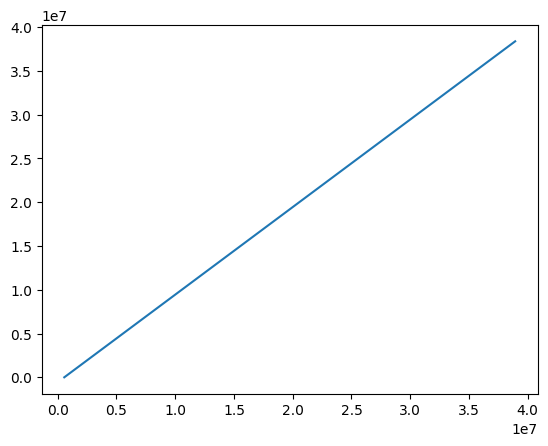

In [31]:
plt.plot(ni_sync,bmi_sync)
plt.show()

In [32]:
# interpolation 1d 
interp_function = interp1d(ni_sync, bmi_sync, fill_value="extrapolate")

In [33]:
ni_sync_interpolated = interp_function(ni_laser) # laser interpolation

In [34]:
ni_sync_interpolated

array([   63188.99448804,   225174.7628349 ,   242101.656279  ,
         607850.35386701,   837784.90641395,   850524.82621532,
        1069401.44837266,  1231679.42682216,  1412743.28701331,
        1439395.11923828,  1818866.73043965,  1831726.64948562,
        2125562.79976782,  2137947.72180392,  2231511.13281613,
        2681364.30096099,  2881575.04062128,  2931408.72691496,
        3300423.40394341,  3487784.22449479,  3619014.39839225,
        3743859.61248346,  4081368.52375628,  4169015.01070508,
        4238327.60497393,  4531439.88919939,  4862604.9506775 ,
        5293901.4260221 ,  5495048.2485805 ,  5575262.77903331,
        5656899.30116229,  6206577.08354504,  6350427.24149763,
        6468975.54755823,  7125825.44227146,  7443974.43291449,
        7687580.89435125,  7881639.66871998,  8000291.91933924,
        8218908.53860619,  8443833.11803348,  8668871.69674079,
        8956467.88034843,  9106495.93280523,  9500801.44246093,
        9612791.7351556 ,  9862878.15566

In [35]:
muaSampRate = 25000
ni_laser_mua = np.ceil(ni_sync_interpolated / niSampRate * muaSampRate).astype(np.int64)

In [39]:
ni_laser_mua

array([   25276,    90070,    96841,   243140,   335114,   340210,
         427760,   492671,   565096,   575757,   727545,   732689,
         850223,   855177,   892603,  1072543,  1152627,  1172561,
        1320166,  1395111,  1447602,  1497540,  1632544,  1667602,
        1695327,  1812572,  1945037,  2117556,  2198014,  2230100,
        2262754,  2482625,  2540165,  2587584,  2850323,  2977582,
        3075025,  3152648,  3200109,  3287555,  3377525,  3467540,
        3582578,  3642589,  3800311,  3845107,  3945141,  4062646,
        4105080,  4147790,  4240037,  4277785,  4347636,  4457576,
        4495027,  4667592,  4750080,  4882677,  4942938,  5065047,
        5172627,  5217588,  5407573,  5607530,  5650183,  5775102,
        5992533,  6047539,  6087546,  6222616,  6335119,  6390563,
        6500028,  6560031,  6615083,  6672717,  6737695,  6795041,
        6870031,  6947917,  7042524,  7082580,  7135064,  7340120,
        7375314,  7417789,  7470056,  7512715,  7627622,  7735

In [37]:
# concatenate mua and laser 
duration_frame = muaSampRate // 1000
mua['LASER'] = 0
laser_signal_mua = np.repeat(ni_laser_mua, duration_frame) + np.tile(np.arange(duration_frame), len(ni_laser_mua))

mua.loc[laser_signal_mua, 'LASER'] = 1
mua

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,LASER
0,1772610,1746570,1814504,1814190,1959300,2009174,1842540,2075534,1930004,1923074,...,-3701420,-3701420,-3700790,-3703940,-3702154,-3702890,-3700580,-3704674,-3703834,0
1,3171108,3127568,3242046,3244950,3505170,3590950,3292920,3707664,3439766,3439814,...,-6387854,-6389954,-6387678,-6394652,-6389478,-6390262,-6388248,-6394282,-6392156,0
2,4646292,4587590,4744348,4750328,5137424,5265722,4824440,5430392,5036786,5038248,...,-9237320,-9241164,-9236518,-9245910,-9240744,-9241412,-9238808,-9246306,-9242572,0
3,6749058,6666596,6895420,6890634,7457934,7654426,7004576,7888818,7319016,7318596,...,-13298148,-13305074,-13297674,-13310618,-13303018,-13304714,-13300562,-13311532,-13305012,0
4,9936268,9797790,10151444,10136190,10966724,11257404,10305036,11605254,10762824,10765880,...,-19422542,-19431654,-19424100,-19441610,-19431018,-19433798,-19426244,-19442356,-19432298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15616753,-330534,-33810,292672,8954,182352,-259260,-346814,-390782,200098,538740,...,80992,-29556,-78172,119138,15590,-10640,-11408,-28324,56330,0
15616754,-273610,-121582,392316,-67968,140378,-24540,-389874,-372808,385024,665056,...,62470,-30610,-41476,82108,7332,-18698,-13448,-30780,60140,0
15616755,-142422,-137732,441256,-120842,36096,289998,-398766,-267326,594076,771872,...,25372,-29796,-3682,27330,-8336,-31274,-15996,-32704,55208,0
15616756,41630,-18330,424194,-132530,-83136,603924,-369996,-82804,747470,835968,...,-21894,-21880,26594,-28558,-28674,-44966,-14498,-29718,47000,0


In [42]:
len(mua[mua['LASER']==1])

4425

In [43]:
177 * 25

4425